#Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


import itertools
import matplotlib.pyplot as plt

SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#uploading local dataset (CSV File)
from google.colab import files
uploaded = files.upload()

Saving Olympian Bio and Medal Results.csv to Olympian Bio and Medal Results.csv


In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Olympian Bio and Medal Results.csv']))

#Extracting Raw Data

In [ ]:
#From CSV file
csvFile = "Olympian Bio and Medal Results.csv"
csv_data = pd.read_csv(csvFile)
csv_data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [ ]:
#extracting the desired columns
csv_raw = pd.DataFrame(csv_data[["Sex","Age","Height","Weight","Team","Sport","Medal"]])
csv_raw.head()

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,NaN
1,M,23.0,170.0,60.0,China,Judo,NaN
2,M,24.0,NaN,NaN,Denmark,Football,NaN
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,NaN


#Cleaning Up and Preparation of Data

In [ ]:
#replacing the gold, silver, and broze medals as 1
csv_raw["Medal"] = csv_raw["Medal"].map({'Gold': 1, 'Silver': 1, 'Bronze': 1})

#replacing all NaN values in the "Medal" column with 0
csv_raw["Medal"] = csv_raw.Medal.fillna(0)

#to check
csv_raw

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,0.0
1,M,23.0,170.0,60.0,China,Judo,0.0
2,M,24.0,NaN,NaN,Denmark,Football,0.0
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,1.0
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,0.0
...,...,...,...,...,...,...,...
271111,M,29.0,179.0,89.0,Poland-1,Luge,0.0
271112,M,27.0,176.0,59.0,Poland,Ski Jumping,0.0
271113,M,27.0,176.0,59.0,Poland,Ski Jumping,0.0
271114,M,30.0,185.0,96.0,Poland,Bobsleigh,0.0


In [ ]:
#check if there is a need to remove empty cells
csv_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     271116 non-null  object 
 1   Age     261642 non-null  float64
 2   Height  210945 non-null  float64
 3   Weight  208241 non-null  float64
 4   Team    271116 non-null  object 
 5   Sport   271116 non-null  object 
 6   Medal   271116 non-null  float64
dtypes: float64(4), object(3)
memory usage: 14.5+ MB


In [ ]:
#removing rows with empty cells
csv_data = csv_raw.dropna()
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     206165 non-null  object 
 1   Age     206165 non-null  float64
 2   Height  206165 non-null  float64
 3   Weight  206165 non-null  float64
 4   Team    206165 non-null  object 
 5   Sport   206165 non-null  object 
 6   Medal   206165 non-null  float64
dtypes: float64(4), object(3)
memory usage: 12.6+ MB


In [ ]:
#change the "Medal" column to categorical type
csv_data["Medal"] = csv_data["Medal"].astype('category')

#verify the change
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Sex     206165 non-null  object  
 1   Age     206165 non-null  float64 
 2   Height  206165 non-null  float64 
 3   Weight  206165 non-null  float64 
 4   Team    206165 non-null  object  
 5   Sport   206165 non-null  object  
 6   Medal   206165 non-null  category
dtypes: category(1), float64(3), object(3)
memory usage: 11.2+ MB


count     206165.0
unique         2.0
top            0.0
freq      175984.0
Name: Medal, dtype: float64


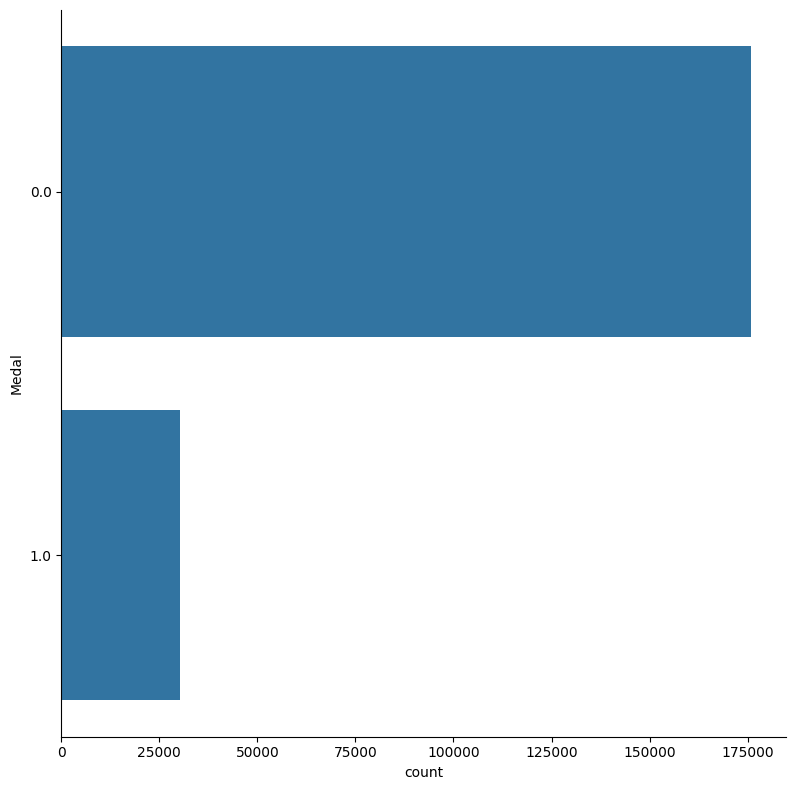

In [ ]:
#evaluating the difference between the two medal classes
print (csv_data['Medal'].describe())
sb.catplot(y = 'Medal', data = csv_data, kind = "count", height = 8)

This could present errors later on during the machine learning phase as there is a wide discrepancy between the two classes. This would most likely cause a lot of error in predicting the Y class and will result in a very high FNR . To prevent this, we will try to even out the two classes.

##Evening out the N and Y Classes

In [ ]:
#extracting only the male athletes in Athletics who won medals
data_medals = csv_data[(csv_data.Medal == 1)
              & (csv_data.Sex == "M")
              & (csv_data.Sport == "Athletics")]
data_medals

,Sex,Age,Height,Weight,Team,Sport,Medal
191,M,26.0,182.0,67.0,Spain,Athletics,1.0
620,M,26.0,190.0,125.0,Unified Team,Athletics,1.0
655,M,21.0,160.0,50.0,Ethiopia,Athletics,1.0
720,M,22.0,166.0,58.0,Ethiopia,Athletics,1.0
727,M,19.0,181.0,78.0,Sweden,Athletics,1.0
...,...,...,...,...,...,...,...
270550,M,23.0,190.0,102.0,Hungary,Athletics,1.0
270551,M,27.0,190.0,102.0,Hungary,Athletics,1.0
270552,M,31.0,190.0,102.0,Hungary,Athletics,1.0
270761,M,20.0,175.0,62.0,Italy,Athletics,1.0


In [ ]:
#choosing the team with the most number of medals won in swimming
n=1
data_medals.value_counts(["Team"])[:n].index.tolist()

[('United States',)]

In [ ]:
#extract data from United States, Jamaica, Kenya, Trinidad and Tobago
clean_data = csv_data[(csv_data.Sex == "M") & ((csv_data.Team == "United States")|
                    (csv_data.Team == "Jamaica")|(csv_data.Team == "Kenya")|
                    (csv_data.Team == "	Trinidad and Tobago"))
                    & (csv_data.Sport == "Athletics")]

#reset indexes
clean_data = clean_data.reset_index()
clean_data = clean_data.drop(['index'], axis = 1)
clean_data

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,26.0,183.0,75.0,United States,Athletics,0.0
1,M,23.0,178.0,61.0,United States,Athletics,0.0
2,M,27.0,178.0,61.0,United States,Athletics,0.0
3,M,31.0,178.0,61.0,United States,Athletics,0.0
4,M,35.0,178.0,61.0,United States,Athletics,0.0
...,...,...,...,...,...,...,...
2768,M,23.0,193.0,89.0,United States,Athletics,0.0
2769,M,21.0,180.0,68.0,United States,Athletics,0.0
2770,M,25.0,180.0,68.0,United States,Athletics,0.0
2771,M,31.0,175.0,69.0,United States,Athletics,0.0


In [ ]:
#validate if no. of 1 and 0 classes are similar
clean_data ['Medal'].value_counts()

,count
Medal,
0.0,1851
1.0,922


# Execution of Artificial Neural Network

#### There is a total of 2773 rows. We will be using 80% of the data as the training set and 20% of the data as the test set. The training data will have 2218 rows and the test data will have 555 rows.

In [ ]:
class_counts = clean_data['Medal'].value_counts()
benchMark = class_counts.max() / class_counts.sum()
benchMark

0.6675081139560043

# Training the Data for Age

In [ ]:
clean_data_medal = pd.DataFrame(clean_data['Medal'])
clean_data_numerical = pd.DataFrame(clean_data[['Age','Weight','Height']])

In [ ]:
testSize = 0.2
cleandata_age = pd.DataFrame(clean_data_numerical['Age'])
age_train_data, age_test_data, medal_train_data, medal_test_data = train_test_split(cleandata_age, clean_data_medal,
                                                                                    test_size = testSize,
                                                                                    stratify = clean_data_medal,
                                                                                    random_state=SEED)

In [ ]:
labelEncoder = LabelEncoder()
labelEncoder.fit(clean_data_medal)

y_train = labelEncoder.transform(medal_train_data)
y_test = labelEncoder.transform(medal_test_data)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.7488183659689399, 1: 1.5047489823609226}

According to DLWP, for a binary classification, it is recommended that we use `RMSProp` as our optimizer, `Binary_Crossentropy` as our loss function, `reLU` as our activation and `Sigmoid` as our last layer of activation.

## Optimizer
#### For the optimizer we will be using `Root Mean Squared Propagation (RMSProp)`. As this approach can speed up optimization by consolidating functions, resulting in more effective outcomes.

## Loss Function
#### Since the primary task is a binary classification, the output will be a probability. Hence, it is best to use `Binary_Crossentropy` loss since we are dealing with models that outputs probabilities.

## Activation
#### We will be using `ReLU` in Hidden Layers and `Sigmoid` in Output Layer. These were chosen as `ReLU` is effective in preventing the vanishing gradient problem, this will allow the network to learn more efficiently by keeping neurons active and engaged during training. It also ensures that neurons don't get stuck in an inactive state, which helps the model perform better. On the other hand, the `Sigmoid` function is used in the final layer because it outputs values between 0 and 1, which can be easily interpreted as probabilities, making it a good fit for binary classification problems like ours.


In [ ]:
input_dimension = age_train_data.shape[1]
output_dimension = 1

optimizer_choice = 'rmsprop'
loss_function = 'binary_crossentropy'
evaluation_metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [ ]:
#initialising the ANN model
predictionModel_age = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(input_dimension,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(output_dimension, activation="sigmoid")
])

predictionModel_age.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 128)                 │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate = 0.001

predictionModel_age.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss=loss_function, metrics=evaluation_metrics)

In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_age.get_weights()
predictionModel_age.set_weights(baselineInitialWeights)

benchmarkModel = predictionModel_age.fit(age_train_data, y_train,
                                      batch_size=batch_size,
                                      class_weight=class_weight_dict,
                                      epochs=EPOCHS,
                                      verbose=0)

In [ ]:
benchmarkAgeScores = predictionModel_age.evaluate(age_train_data, y_train, verbose=0)[1:]

print('Accuracy  (AGE TRAIN): {:.2f}'.format(benchmarkAgeScores[0]))
print('Precision (AGE TRAIN): {:.2f}'.format(benchmarkAgeScores[1]))
print('Recall    (AGE TRAIN): {:.2f}'.format(benchmarkAgeScores[2]))
print('AUC       (AGE TRAIN): {:.2f}'.format(benchmarkAgeScores[3]))

Accuracy  (AGE TRAIN): 0.50
Precision (AGE TRAIN): 0.36
Recall    (AGE TRAIN): 0.70
AUC       (AGE TRAIN): 0.56


In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_age.get_weights()
predictionModel_age.set_weights(baselineInitialWeights)

benchmarkModel = predictionModel_age.fit(age_test_data, y_test,
                                      batch_size=batch_size,
                                      class_weight=class_weight_dict,
                                      epochs=EPOCHS,
                                      verbose=0)

In [ ]:
benchmarkAgeScores = predictionModel_age.evaluate(age_test_data, y_test, verbose=0)[1:]

print('Accuracy  (AGE TEST): {:.2f}'.format(benchmarkAgeScores[0]))
print('Precision (AGE TEST): {:.2f}'.format(benchmarkAgeScores[1]))
print('Recall    (AGE TEST): {:.2f}'.format(benchmarkAgeScores[2]))
print('AUC       (AGE TEST): {:.2f}'.format(benchmarkAgeScores[3]))

Accuracy  (AGE TEST): 0.41
Precision (AGE TEST): 0.34
Recall    (AGE TEST): 0.80
AUC       (AGE TEST): 0.51


# Training the Data for HEIGHT

In [ ]:
testSize = 0.2
cleandata_height = pd.DataFrame(clean_data_numerical['Height'])
height_train_data, height_test_data, medal_train_data, medal_test_data = train_test_split(cleandata_height, clean_data_medal,
                                                                      stratify = clean_data_medal,
                                                                      test_size = testSize,
                                                                      random_state=SEED)

In [ ]:
input_height_dimension = height_train_data.shape[1]

optimizer_choice = 'rmsprop'
loss_function = 'binary_crossentropy'
evaluation_metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [ ]:
predictionModel_height = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(input_height_dimension,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

predictionModel_height.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate = 0.001

predictionModel_height.compile(optimizer=RMSprop(learning_rate=learning_rate),
                            loss=loss_function, metrics=evaluation_metrics)

In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_height.get_weights()
predictionModel_height.set_weights(baselineInitialWeights)

benchmarkHeightModel = predictionModel_height.fit(height_train_data, y_train,
                                   class_weight=class_weight_dict,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [ ]:
benchmarkHeightScores = predictionModel_height.evaluate(height_train_data, y_train, verbose=0)[1:]

print('Accuracy  (HEIGHT TRAIN): {:.2f}'.format(benchmarkHeightScores[0]))
print('Precision (HEIGHT TRAIN): {:.2f}'.format(benchmarkHeightScores[1]))
print('Recall    (HEIGHT TRAIN): {:.2f}'.format(benchmarkHeightScores[2]))
print('AUC       (HEIGHT TRAIN): {:.2f}'.format(benchmarkHeightScores[3]))

Accuracy  (HEIGHT TRAIN): 0.67
Precision (HEIGHT TRAIN): 0.00
Recall    (HEIGHT TRAIN): 0.00
AUC       (HEIGHT TRAIN): 0.50


In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_height.get_weights()
predictionModel_height.set_weights(baselineInitialWeights)

benchmarkHeightModel = predictionModel_height.fit(height_test_data, y_test,
                                   class_weight=class_weight_dict,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [ ]:
benchmarkHeightScores = predictionModel_height.evaluate(height_test_data, y_test, verbose=0)[1:]

print('Accuracy  (HEIGHT TEST): {:.2f}'.format(benchmarkHeightScores[0]))
print('Precision (HEIGHT TEST): {:.2f}'.format(benchmarkHeightScores[1]))
print('Recall    (HEIGHT TEST): {:.2f}'.format(benchmarkHeightScores[2]))
print('AUC       (HEIGHT TEST): {:.2f}'.format(benchmarkHeightScores[3]))

Accuracy  (HEIGHT TEST): 0.33
Precision (HEIGHT TEST): 0.33
Recall    (HEIGHT TEST): 1.00
AUC       (HEIGHT TEST): 0.50


# Training the Data for WEIGHT

In [ ]:
testSize = 0.2
cleandata_weight = pd.DataFrame(clean_data_numerical['Weight'])
weight_train_data, weight_test_data, medal_train_data, medal_test_data = train_test_split(cleandata_weight, clean_data_medal,
                                                                      stratify = clean_data_medal,
                                                                      test_size = testSize,
                                                                      random_state=SEED)

In [ ]:
input_weight_dimension = weight_train_data.shape[1]

optimizer_choice = 'rmsprop'
loss_function = 'binary_crossentropy'
evaluation_metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [ ]:
predictionModel_weight = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(input_weight_dimension,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

predictionModel_weight.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 128)                 │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate = 0.001

predictionModel_weight.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss=loss_function, metrics=evaluation_metrics)

In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_weight.get_weights()
predictionModel_weight.set_weights(baselineInitialWeights)

benchmarkWeightModel = predictionModel_weight.fit(weight_train_data, y_train,
                                   class_weight=class_weight_dict,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [ ]:
benchmarkWeightScores = predictionModel_weight.evaluate(weight_train_data, y_train, verbose=0)[1:]

print('Accuracy  (WEIGHT TRAIN): {:.2f}'.format(benchmarkWeightScores[0]))
print('Precision (WEIGHT TRAIN): {:.2f}'.format(benchmarkWeightScores[1]))
print('Recall    (WEIGHT TRAIN): {:.2f}'.format(benchmarkWeightScores[2]))
print('AUC       (WEIGHT TRAIN): {:.2f}'.format(benchmarkWeightScores[3]))

Accuracy  (WEIGHT TRAIN): 0.52
Precision (WEIGHT TRAIN): 0.38
Recall    (WEIGHT TRAIN): 0.74
AUC       (WEIGHT TRAIN): 0.60


In [ ]:
EPOCHS = 100
batch_size=64

baselineInitialWeights = predictionModel_weight.get_weights()
predictionModel_weight.set_weights(baselineInitialWeights)

benchmarkWeightModel = predictionModel_weight.fit(weight_test_data, y_test,
                                   class_weight=class_weight_dict,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [ ]:
benchmarkWeightScores = predictionModel_weight.evaluate(weight_test_data, y_test, verbose=0)[1:]

print('Accuracy  (WEIGHT TEST): {:.2f}'.format(benchmarkWeightScores[0]))
print('Precision (WEIGHT TEST): {:.2f}'.format(benchmarkWeightScores[1]))
print('Recall    (WEIGHT TEST): {:.2f}'.format(benchmarkWeightScores[2]))
print('AUC       (WEIGHT TEST): {:.2f}'.format(benchmarkWeightScores[3]))

Accuracy  (WEIGHT TEST): 0.53
Precision (WEIGHT TEST): 0.37
Recall    (WEIGHT TEST): 0.60
AUC       (WEIGHT TEST): 0.53
